# Predicción de Mercados usando Tensorflow

### Import de librerías

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from datetime import datetime

2023-05-15 11:45:57.411315: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-15 11:45:57.653191: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-15 11:45:57.654408: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-15 11:45:58.625272: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Import de los datos

In [2]:
data = pd.read_csv('./stocks/TSLA_5yr.csv')
print(data.shape)
print(data.sample(7))

data['Date'] = pd.to_datetime(data['Date'])

(1258, 7)
            Date        Open        High         Low       Close   Adj Close  \
827   2021-07-22  218.813339  220.723328  214.866669  216.419998  216.419998   
556   2020-06-24   66.274002   66.725334   63.542667   64.056664   64.056664   
1146  2022-10-26  219.399994  230.600006  218.199997  224.639999  224.639999   
248   2019-04-04   17.459333   18.080000   17.372667   17.851999   17.851999   
186   2019-01-04   20.400000   21.200001   20.181999   21.179333   21.179333   
0     2018-04-10   19.931334   20.473333   19.578667   20.313334   20.313334   
418   2019-12-05   22.188667   22.294666   21.816668   22.024668   22.024668   

         Volume  
827    45317100  
556   164394000  
1146   85012500  
248   355810500  
186   110911500  
0     164847000  
418    55869000  


### Mostramos las velas diarias

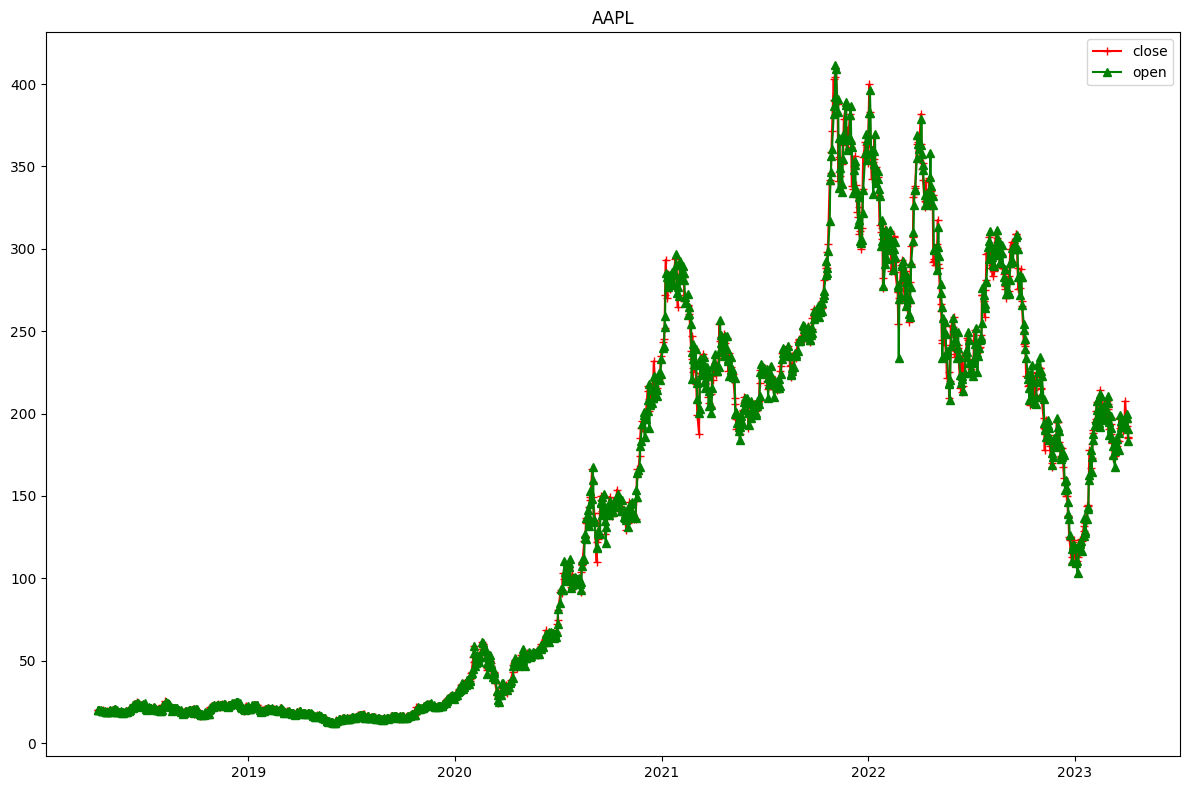

In [3]:
plt.figure(figsize=(12, 8))
plt.plot(data['Date'], data['Close'], c="r", label="close", marker="+")
plt.plot(data['Date'], data['Open'], c="g", label="open", marker="^")
plt.title("AAPL")
plt.legend()
plt.tight_layout()

### Mostramos el volumen diario

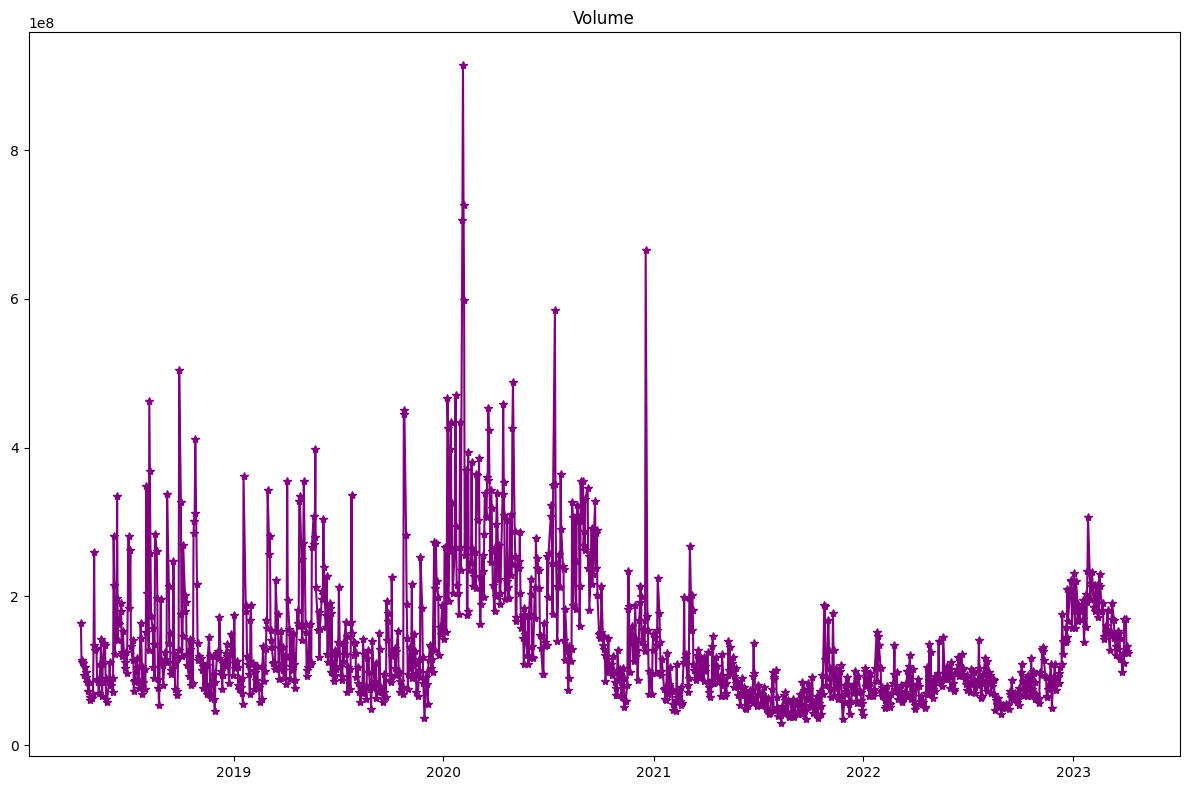

In [4]:
plt.figure(figsize=(12, 8))
plt.plot(data['Date'], data['Volume'], c='purple', marker='*')
plt.title("Volume")
plt.tight_layout()

### Mostramos los datos de entreno

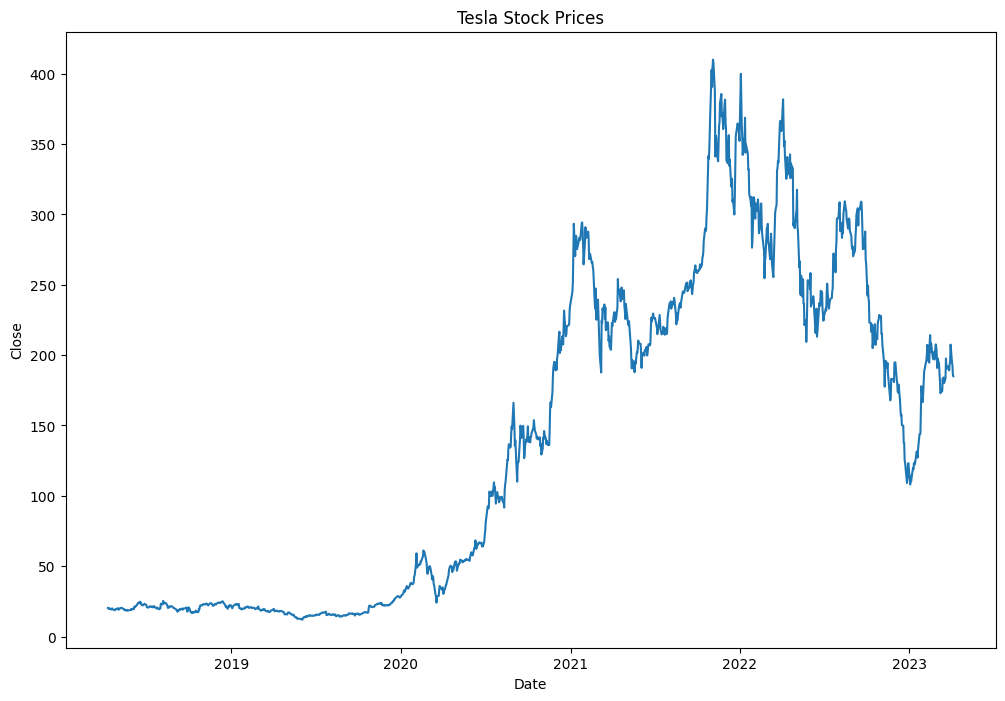

In [5]:
prediction_range = data.loc[(data['Date'] > datetime(2018,3,27)) & (data['Date'] < datetime(2023,3,27))]
plt.figure(figsize=(12, 8))
plt.plot(data['Date'], data['Close'])
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Tesla Stock Prices")
plt.show()

### Establecemos el set de entrenamiento y otro para la validación (95%/5%)

In [6]:
close_data = data.filter(['Close'])
dataset = close_data.values
training = int(np.ceil(len(dataset) * .95))
testing = int(np.floor(len(dataset) * .05))
print(training) 
print(testing)

1196
62


### Preparamos los datos para el entrenamiento

In [7]:
from sklearn.preprocessing import MinMaxScaler
  
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
  
train_data = scaled_data[0:int(training), :]

x_train = []
y_train = []
  
for i in range(testing, len(train_data)):
    x_train.append(train_data[i - testing:i, 0])
    y_train.append(train_data[i, 0])
  
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

### Preparamos el modelo

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 62, 64)            16896     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 52,033
Trainable params: 52,033
Non-trainable params: 0
_________________________________________________________________


2023-05-15 11:46:25.429069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 11:46:25.430144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 11:46:25.430866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

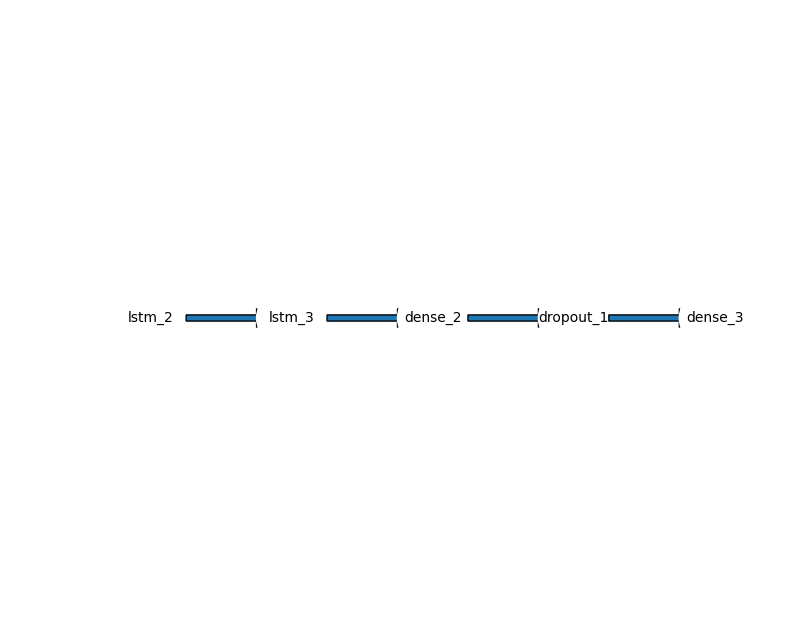

In [13]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64,
							return_sequences=True,
							input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.summary()

# Crear una lista con los nombres de las capas de la red
layer_names = [layer.name for layer in model.layers]

# Configuración visual
circle_radius = 0.2
arrow_width = 0.01
figure_size = (10, 8)

# Crear una figura y un conjunto de ejes
fig, ax = plt.subplots(figsize=figure_size)

# Crear un diagrama de capas utilizando círculos y flechas
for i, layer_name in enumerate(layer_names):
    # Calcular las coordenadas x, y de los círculos de las capas
    x = i * 0.2 + 0.1
    y = 0.5

    # Dibujar el círculo de la capa
    circle = plt.Circle((x, y), circle_radius, color='lightblue', edgecolor='black')
    ax.add_patch(circle)
    ax.text(x, y, layer_name, ha='center', va='center')

    # Dibujar las flechas de conexión entre las capas
    if i < len(layer_names) - 1:
        ax.arrow(x + circle_radius, y, 0.2 - circle_radius * 2, 0, width=arrow_width, edgecolor='black', color='black',
                 length_includes_head=True, head_length=0.03)

# Establecer límites de los ejes y ocultar las etiquetas
ax.set_xlim(-0.1, len(layer_names) * 0.2)
ax.set_ylim(0, 1)
ax.axis('off')

# Mostrar el diagrama de capas
plt.show()

### Procedemos a entrenar el modelo

In [9]:
model.compile(optimizer='adam',
              loss='mean_squared_error')
history = model.fit(x_train,
                    y_train,
                    epochs=10)

Epoch 1/10


2023-05-15 11:46:01.902043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 11:46:01.903496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 11:46:01.904991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

36/36 [==============================] - 4s 56ms/step - loss: 0.0306
Epoch 2/10
36/36 [==============================] - 2s 58ms/step - loss: 0.0097
Epoch 3/10
36/36 [==============================] - 2s 56ms/step - loss: 0.0082
Epoch 4/10
36/36 [==============================] - 2s 56ms/step - loss: 0.0080
Epoch 5/10
36/36 [==============================] - 2s 61ms/step - loss: 0.0077
Epoch 6/10
36/36 [==============================] - 2s 57ms/step - loss: 0.0079
Epoch 7/10
36/36 [==============================] - 2s 55ms/step - loss: 0.0070
Epoch 8/10
36/36 [==============================] - 2s 58ms/step - loss: 0.0065
Epoch 9/10
36/36 [==============================] - 2s 57ms/step - loss: 0.0066
Epoch 10/10
36/36 [==============================] - 2s 53ms/step - loss: 0.0063


### Establecemos los datos de prueba, generamos la predicción y los MSE

In [10]:
test_data = scaled_data[training - testing:, :]

x_test = []
y_test = dataset[training:, :]
for i in range(testing, len(test_data)):
    x_test.append(test_data[i-testing:i, 0])
  
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
  
# prediccion de los datos de prueba
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
  
# metricas MSE (Error Cuadrático Medio) y RMSE (Raiz del Error Cuadrático Medio)
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))

2023-05-15 11:46:24.616952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 11:46:24.618403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 11:46:24.619441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 19ms/step
MSE 163.62503367853142
RMSE 12.791600121897629


### Mostramos el resultado final con la predicción, entrenamiento y pruebas

/tmp/ipykernel_1590/1461219673.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


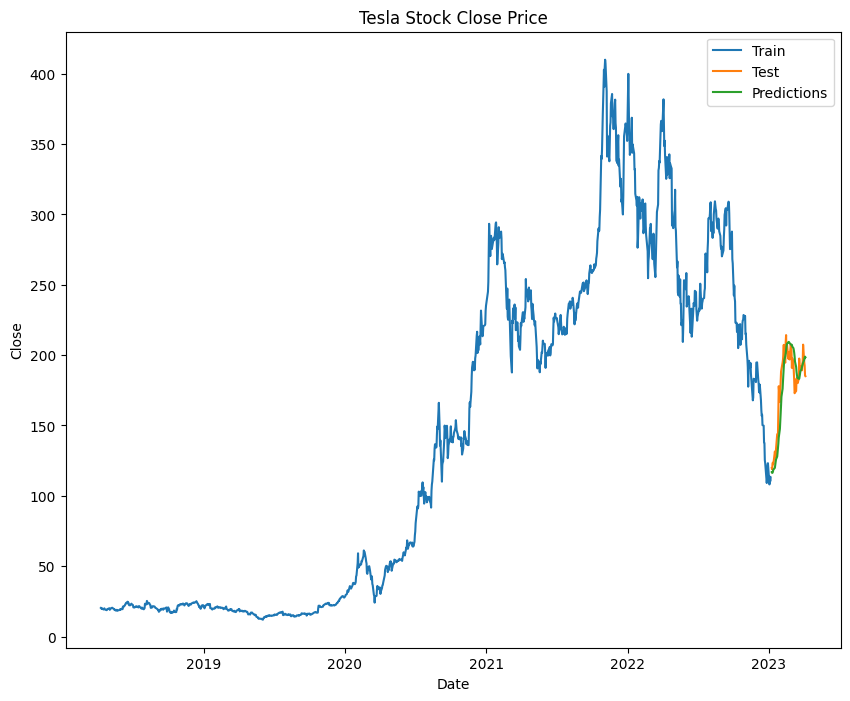

In [11]:
train = data[:training]
test = data[training:]
test['Predictions'] = predictions
  
plt.figure(figsize=(10, 8))
plt.plot(train['Date'], train['Close'])
plt.plot(test['Date'], test[['Close', 'Predictions']])
plt.title('Tesla Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])
# plt.axis([2022,2023,120,180])

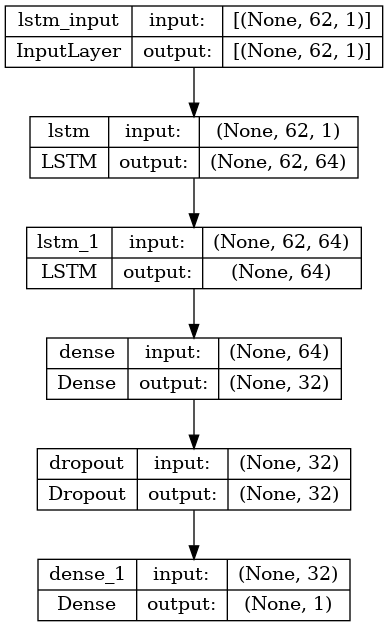

In [12]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
